Initial dataset shape: (1005167, 5)
Dataset shape after removing duplicates: (1005167, 5)
Number of missing `date_of_order` entries after conversion: 0
Earliest date used for missing `date_of_order`: 2022-01-01 00:00:00
Missing values after filling missing data:
product_number     0
department_desc    0
discount           0
date_of_order      0
orders             0
dtype: int64


/Users/atiyamahboob/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


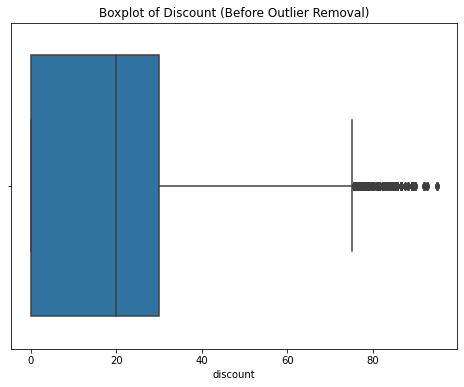

/Users/atiyamahboob/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


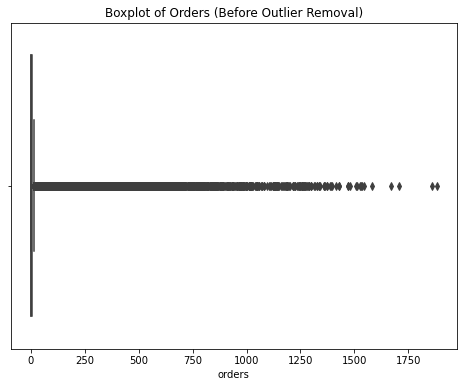

Processing outliers for column: discount
Initial discount stats:
count    1.005167e+06
mean     1.947619e+01
std      1.795579e+01
min      0.000000e+00
25%      0.000000e+00
50%      2.000000e+01
75%      3.000000e+01
max      9.496000e+01
Name: discount, dtype: float64
Number of outliers removed from `discount`: 2406
Processing outliers for column: orders
Initial orders stats:
count    1.002761e+06
mean     9.087893e+00
std      3.361184e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      5.000000e+00
max      1.883000e+03
Name: orders, dtype: float64
Number of outliers removed from `orders`: 11423
Dataset shape after removing outliers: (991338, 5)


/Users/atiyamahboob/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


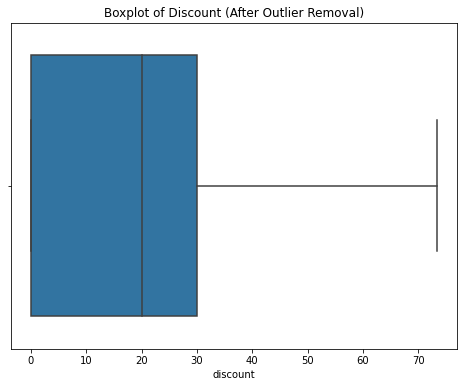

/Users/atiyamahboob/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


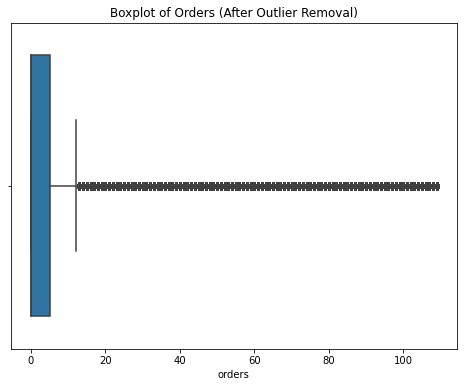

Skewness before log transformation:
Discount: 0.5910148722536838, Orders: 3.555725750381286
Log transformation applied to `discount` and `orders`.
Skewness after log transformation:
Log Discount: -0.5594750015977868, Log Orders: 0.8962893249156177
Summary statistics for Log Discount:
count    991338.000000
mean          2.233270
std           1.552376
min           0.000000
25%           0.000000
50%           3.044522
75%           3.433987
max           4.308515
Name: log_discount, dtype: float64
Summary statistics for Log Orders:
count    991338.000000
mean          0.994010
std           1.314039
min           0.000000
25%           0.000000
50%           0.000000
75%           1.791759
max           4.700480
Name: log_orders, dtype: float64


/Users/atiyamahboob/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


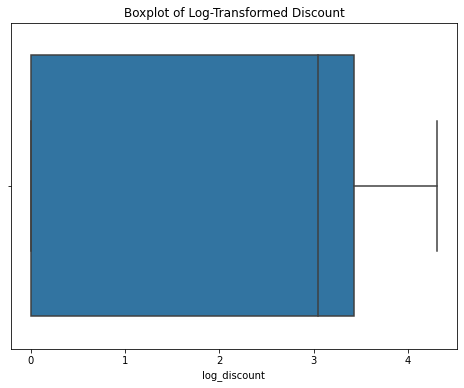

/Users/atiyamahboob/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


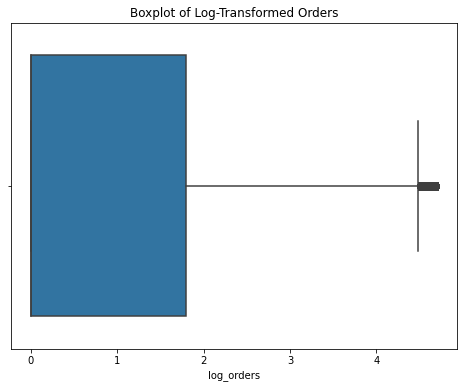

Feature engineering complete. Added 'day_of_week', 'month', and 'year'.
Processing `discount_x_product` feature...
Feature `discount_x_product` added.
Converted `department_desc` to categorical.
Remaining missing values after preprocessing:
product_number        0
department_desc       0
discount              0
date_of_order         0
orders                0
log_discount          0
log_orders            0
day_of_week           0
month                 0
year                  0
discount_x_product    0
dtype: int64
Cleaned dataset saved as 'cleaned_orders_discount_data.csv'.


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import zscore

# Load the dataset
file_path = '2022_orders_discount_data.csv'
data_cleaned = pd.read_csv(file_path)
print(f"Initial dataset shape: {data_cleaned.shape}")

# 1. Remove duplicates
data_cleaned = data_cleaned.drop_duplicates()
print(f"Dataset shape after removing duplicates: {data_cleaned.shape}")

# 2. Convert `date_of_order` to datetime format
data_cleaned['date_of_order'] = pd.to_datetime(data_cleaned['date_of_order'], errors='coerce')
print(f"Number of missing `date_of_order` entries after conversion: {data_cleaned['date_of_order'].isnull().sum()}")

# Handle missing `date_of_order` values
min_date = data_cleaned['date_of_order'].min()  # Use the earliest date in the dataset
data_cleaned['date_of_order'] = data_cleaned['date_of_order'].fillna(min_date)
print(f"Earliest date used for missing `date_of_order`: {min_date}")

# 3. Handle missing values in other columns
data_cleaned['department_desc'] = data_cleaned['department_desc'].fillna('Unknown')  # Fill NaNs with 'Unknown'
data_cleaned['discount'] = data_cleaned['discount'].fillna(0)  # Replace NaN in `discount` with 0
data_cleaned['orders'] = data_cleaned['orders'].fillna(0)  # Replace NaN in `orders` with 0
print(f"Missing values after filling missing data:\n{data_cleaned.isnull().sum()}")

# Visualize initial boxplots for outliers
plt.figure(figsize=(8, 6))
sns.boxplot(data_cleaned['discount'])
plt.title("Boxplot of Discount (Before Outlier Removal)")
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(data_cleaned['orders'])
plt.title("Boxplot of Orders (Before Outlier Removal)")
plt.show()

# 4. Handle outliers using Z-Score
def remove_outliers_zscore(df, column, threshold=3):
    print(f"Processing outliers for column: {column}")
    print(f"Initial {column} stats:\n{df[column].describe()}")
    z_scores = zscore(df[column])
    abs_z_scores = np.abs(z_scores)
    filtered_entries = abs_z_scores < threshold
    print(f"Number of outliers removed from `{column}`: {len(df) - filtered_entries.sum()}")
    return df[filtered_entries]

data_cleaned = remove_outliers_zscore(data_cleaned, 'discount', threshold=3)
data_cleaned = remove_outliers_zscore(data_cleaned, 'orders', threshold=3)
print(f"Dataset shape after removing outliers: {data_cleaned.shape}")

# Visualize boxplots after outlier removal
plt.figure(figsize=(8, 6))
sns.boxplot(data_cleaned['discount'])
plt.title("Boxplot of Discount (After Outlier Removal)")
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(data_cleaned['orders'])
plt.title("Boxplot of Orders (After Outlier Removal)")
plt.show()

# Skewness Check
print("Skewness before log transformation:")
print(f"Discount: {data_cleaned['discount'].skew()}, Orders: {data_cleaned['orders'].skew()}")

# Log Transformation for skewed variables
data_cleaned['log_discount'] = np.log1p(data_cleaned['discount'])  # log(1 + discount)
data_cleaned['log_orders'] = np.log1p(data_cleaned['orders'])  # log(1 + orders)
print("Log transformation applied to `discount` and `orders`.")

# Skewness After Log Transformation
print("Skewness after log transformation:")
print(f"Log Discount: {data_cleaned['log_discount'].skew()}, Log Orders: {data_cleaned['log_orders'].skew()}")

# Summary Statistics
print("Summary statistics for Log Discount:")
print(data_cleaned['log_discount'].describe())
print("Summary statistics for Log Orders:")
print(data_cleaned['log_orders'].describe())

# Visualize boxplots for log-transformed variables
plt.figure(figsize=(8, 6))
sns.boxplot(data_cleaned['log_discount'])
plt.title("Boxplot of Log-Transformed Discount")
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(data_cleaned['log_orders'])
plt.title("Boxplot of Log-Transformed Orders")
plt.show()

# 5. Feature Engineering: Extract useful features from `date_of_order`
data_cleaned['day_of_week'] = data_cleaned['date_of_order'].dt.dayofweek  # Monday=0, Sunday=6
data_cleaned['month'] = data_cleaned['date_of_order'].dt.month  # Extract month
data_cleaned['year'] = data_cleaned['date_of_order'].dt.year  # Extract year
print("Feature engineering complete. Added 'day_of_week', 'month', and 'year'.")

# 6. Add interaction feature: `discount_x_product`
if 'product_number' in data_cleaned.columns:
    # Ensure `product_number` is numerical
    print("Processing `discount_x_product` feature...")
    if data_cleaned['product_number'].dtype == 'object':
        data_cleaned['product_number'] = pd.to_numeric(data_cleaned['product_number'], errors='coerce').fillna(0)
    data_cleaned['discount_x_product'] = data_cleaned['discount'] * data_cleaned['product_number']
    print("Feature `discount_x_product` added.")
else:
    print("Column `product_number` not found. Skipping `discount_x_product` calculation.")

# 7. Convert `department_desc` to categorical
data_cleaned['department_desc'] = data_cleaned['department_desc'].astype('category')
print("Converted `department_desc` to categorical.")

# Validate if there are any remaining missing values
missing_values = data_cleaned.isnull().sum()
print(f"Remaining missing values after preprocessing:\n{missing_values}")

# Save the cleaned dataset for future use
data_cleaned.to_csv('cleaned_orders_discount_data.csv', index=False)
print("Cleaned dataset saved as 'cleaned_orders_discount_data.csv'.")




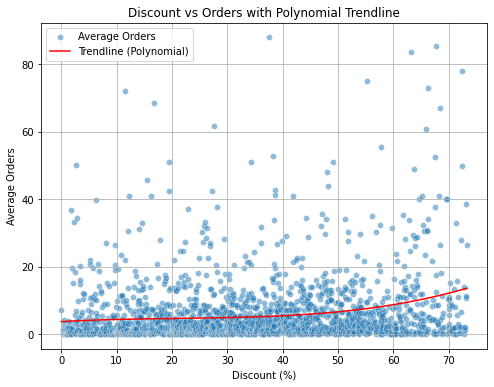

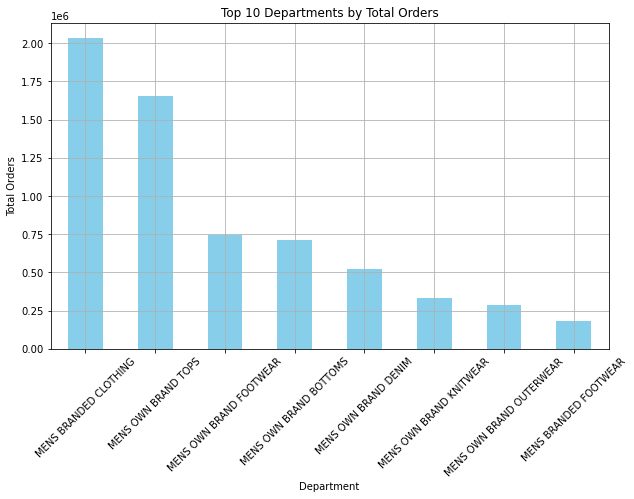

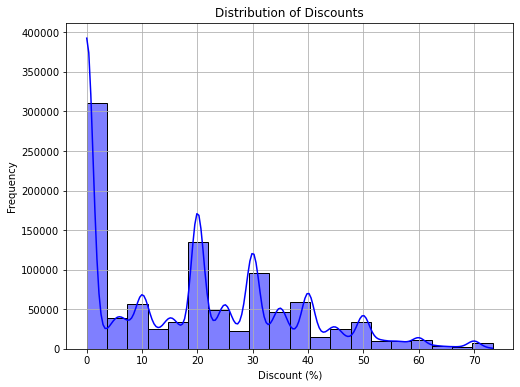

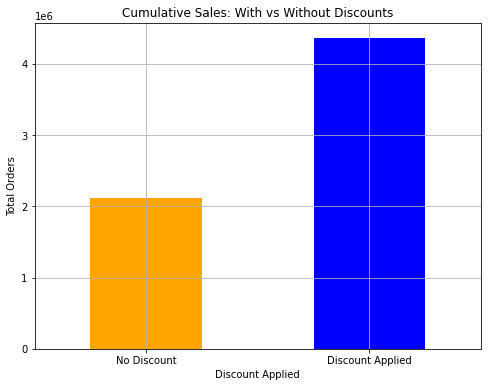

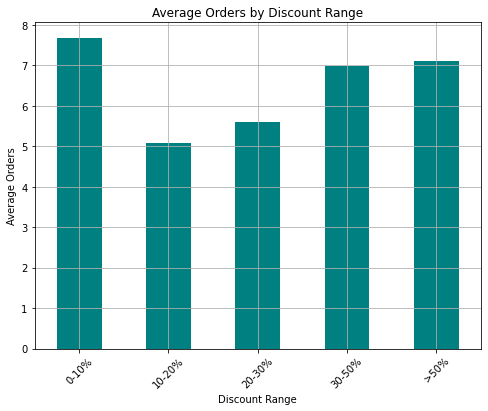

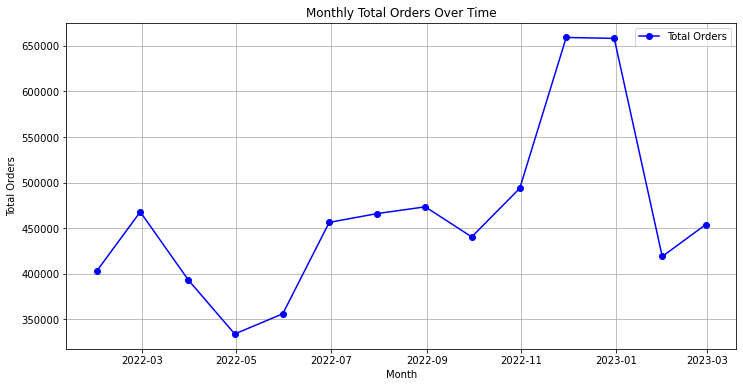

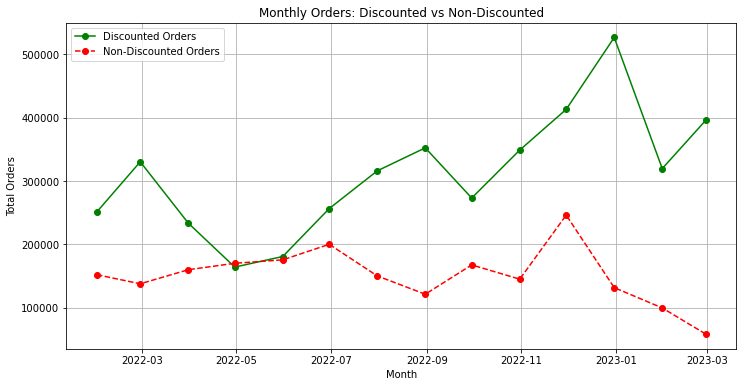

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Assuming `data_cleaned` is already available from Step 1

# 1. Scatter Plot with Aggregated Data and Polynomial Trendline
discount_orders = data_cleaned.groupby('discount')['orders'].mean().reset_index()

# Add polynomial features and fit a polynomial regression model
X = discount_orders[['discount']]
y = discount_orders['orders']
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)
model = LinearRegression()
model.fit(X_poly, y)

# Predict values
discount_orders['predicted_orders'] = model.predict(X_poly)

# Plot the results
plt.figure(figsize=(8, 6))
sns.scatterplot(x='discount', y='orders', data=discount_orders, alpha=0.5, label='Average Orders')
sns.lineplot(x='discount', y='predicted_orders', data=discount_orders, color='red', label='Trendline (Polynomial)')
plt.title('Discount vs Orders with Polynomial Trendline')
plt.xlabel('Discount (%)')
plt.ylabel('Average Orders')
plt.legend()
plt.grid(True)
plt.show()

# Insight
print("Insight: Higher discounts (>30%) tend to have a non-linear effect on increasing orders. However, lower discounts have minimal impact on order volume.")

# 2. Department-wise Discount Sensitivity (Top 10 Departments)
dept_analysis = data_cleaned.groupby('department_desc')['orders'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
dept_analysis.head(10).plot(kind='bar', color='skyblue')  # Show only top 10 departments
plt.title('Top 10 Departments by Total Orders')
plt.xlabel('Department')
plt.ylabel('Total Orders')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Insight
print("Insight: Men's branded clothing and own-brand tops dominate total orders. Promotions should target these high-demand categories for maximum sales impact.")

# 3. Distribution of Discounts
plt.figure(figsize=(8, 6))
sns.histplot(data_cleaned['discount'], bins=20, kde=True, color='blue')
plt.title('Distribution of Discounts')
plt.xlabel('Discount (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Insight
print("Insight: Discounts are heavily concentrated in the 0-20% range, indicating limited use of higher discounts. Consider experimenting with mid-range discounts (30-50%) to boost sales.")

# 4. Cumulative Sales: With vs Without Discounts
data_cleaned['discount_applied'] = data_cleaned['discount'] > 0
cumulative_sales = data_cleaned.groupby('discount_applied')['orders'].sum()

cumulative_sales.plot(kind='bar', color=['orange', 'blue'], figsize=(8, 6))
plt.title('Cumulative Sales: With vs Without Discounts')
plt.xlabel('Discount Applied')
plt.ylabel('Total Orders')
plt.xticks([0, 1], ['No Discount', 'Discount Applied'], rotation=0)
plt.grid(True)
plt.show()

# Insight
print("Insight: Discounted sales contribute significantly more to total orders than non-discounted sales, emphasizing the importance of discounts in driving volume.")

# 5. Effectiveness of Discounts: Average Orders by Discount Range
data_cleaned['discount_range'] = pd.cut(data_cleaned['discount'], bins=[0, 10, 20, 30, 50, 100],
                                        labels=['0-10%', '10-20%', '20-30%', '30-50%', '>50%'])
avg_orders_by_discount = data_cleaned.groupby('discount_range')['orders'].mean()

plt.figure(figsize=(8, 6))
avg_orders_by_discount.plot(kind='bar', color='teal')
plt.title('Average Orders by Discount Range')
plt.xlabel('Discount Range')
plt.ylabel('Average Orders')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Insight
print("Insight: Discounts in the 0-10% and >30% ranges are most effective at generating higher average orders. Mid-range discounts (10-30%) appear less effective.")

# 6. Monthly Sales Over Time
monthly_sales = data_cleaned.resample('M', on='date_of_order')['orders'].sum()

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, marker='o', linestyle='-', color='blue', label='Total Orders')
plt.title('Monthly Total Orders Over Time')
plt.xlabel('Month')
plt.ylabel('Total Orders')
plt.grid(True)
plt.legend()
plt.show()

# Insight
print("Insight: Monthly sales exhibit seasonal spikes, particularly in November and December, likely due to holiday promotions. Plan discount campaigns around these periods.")

# 7. Discounted vs Non-Discounted Orders Over Time
monthly_sales_discounted = data_cleaned[data_cleaned['discount_applied']].resample('M', on='date_of_order')['orders'].sum()
monthly_sales_non_discounted = data_cleaned[~data_cleaned['discount_applied']].resample('M', on='date_of_order')['orders'].sum()

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales_discounted, marker='o', linestyle='-', color='green', label='Discounted Orders')
plt.plot(monthly_sales_non_discounted, marker='o', linestyle='--', color='red', label='Non-Discounted Orders')
plt.title('Monthly Orders: Discounted vs Non-Discounted')
plt.xlabel('Month')
plt.ylabel('Total Orders')
plt.grid(True)
plt.legend()
plt.show()

# Insight
print("Insight: Discounted orders consistently outperform non-discounted orders across all months, reinforcing the value of discount strategies in boosting sales.")




            discount         orders     log_orders   log_discount
count  400250.000000  400250.000000  400250.000000  400250.000000
mean       19.214791      16.174558       2.341558       2.185681
std        18.199883      18.245962       0.885154       1.579893
min         0.000000       4.000000       1.386294       0.000000
25%         0.000000       5.000000       1.609438       0.000000
50%        20.000000       9.000000       2.197225       3.044522
75%        30.610000      20.000000       2.995732       3.453474
max        73.330000     109.000000       4.691348       4.308515
Mann-Whitney U Test P-value: 1.0276362498908191e-21
Kruskal-Wallis Test P-value: 1.0276361021918778e-21
Bootstrap Confidence Interval for Mean Difference: [-0.84820649 -0.57967205]


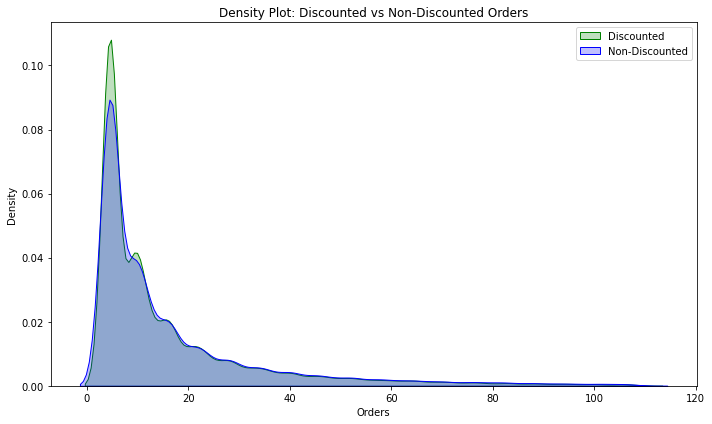

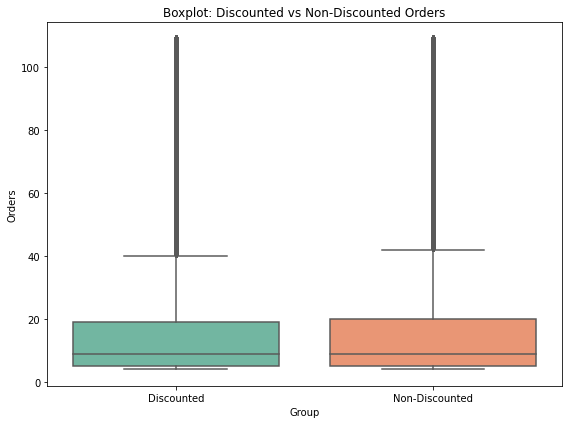

--- Interpretation ---
Null Hypothesis (H0): There is no significant difference in the number of orders between discounted and non-discounted items.
Alternative Hypothesis (H1): There is a significant difference in the number of orders between discounted and non-discounted items.
Conclusion: Reject the null hypothesis. A significant difference exists.


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, kruskal

# --- Step 1: Data Preparation ---
# Load the cleaned data
data = pd.read_csv("cleaned_orders_discount_data.csv")

# Create a 'discount_applied' column if not already present
if 'discount_applied' not in data.columns:
    data['discount_applied'] = (data['discount'] > 0).astype(int)

# Filter rows with non-zero orders for meaningful analysis
data = data[data['orders'] > 0]

# Add log transformations for 'orders' and 'discount' to normalize the data
data['log_orders'] = np.log(data['orders'])
data['log_discount'] = np.log(data['discount'] + 1)  # Adding 1 to avoid log(0)

# Verify the transformed data
print(data[['discount', 'orders', 'log_orders', 'log_discount']].describe())

# --- Step 2: Statistical Tests ---
# Separate the two groups
discounted = data[data['discount_applied'] == 1]['orders']
non_discounted = data[data['discount_applied'] == 0]['orders']

# Remove NaN values (if any)
discounted = discounted.dropna()
non_discounted = non_discounted.dropna()

# Perform statistical tests
mann_whitney_p = mannwhitneyu(discounted, non_discounted, alternative='two-sided').pvalue
kruskal_p = kruskal(discounted, non_discounted).pvalue

# Bootstrap Confidence Interval for mean difference
bootstrap_mean_diff = np.percentile(
    [np.mean(np.random.choice(discounted, len(discounted))) - np.mean(np.random.choice(non_discounted, len(non_discounted)))
     for _ in range(1000)], [2.5, 97.5]
)

# Print results
print("Mann-Whitney U Test P-value:", mann_whitney_p)
print("Kruskal-Wallis Test P-value:", kruskal_p)
print("Bootstrap Confidence Interval for Mean Difference:", bootstrap_mean_diff)

# --- Step 3: Visualization ---
# Density Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(discounted, label="Discounted", color="green", shade=True)
sns.kdeplot(non_discounted, label="Non-Discounted", color="blue", shade=True)
plt.title("Density Plot: Discounted vs Non-Discounted Orders")
plt.xlabel("Orders")
plt.legend()
plt.tight_layout()
plt.show()

# Box Plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=[discounted, non_discounted], palette="Set2")
plt.xticks([0, 1], ["Discounted", "Non-Discounted"])
plt.title("Boxplot: Discounted vs Non-Discounted Orders")
plt.ylabel("Orders")
plt.xlabel("Group")
plt.tight_layout()
plt.show()

# --- Step 4: Interpretation ---
print("--- Interpretation ---")
print("Null Hypothesis (H0): There is no significant difference in the number of orders between discounted and non-discounted items.")
print("Alternative Hypothesis (H1): There is a significant difference in the number of orders between discounted and non-discounted items.")

if mann_whitney_p < 0.05 or kruskal_p < 0.05:
    print("Conclusion: Reject the null hypothesis. A significant difference exists.")
else:
    print("Conclusion: Fail to reject the null hypothesis. No significant difference found.")

